## Mobile App Market Analysis

## Introduction

The explosive growth of the mobile application (app) market has made it difficult for users to find the most interesting and relevant apps from the hundreds of thousands that exist today. We are interested to analyze the quality of apps and understand the user experiences of using mobile apps on the Itune App Store. We think these insights would be helpful for the developers to design better apps, as well as for Apple to better manage the App Store. For example, a good app recommendation system would rely on understanding the quality of apps by predicting their ratings. In this project, we would go through the data science cycle including problem/data curations, data management, data analytics and result-oriented presentations through data visualization.

We are particularily interested in the following questions:
- How do we define the quality of an app?
- Do in-app purchases significantly affect the apps' ratings, especially for gaming apps?
- How do people comment on their user experiences of apps?
- Are there any different characteristics/topics in new version descriptions for apps with their ratings improved/lowered?
- Can we predict the rating of the new version for an app?

In our workflow, firstly, we used `scrapy`, a high level web scraping framework to collect our data from Itune App Store and then stored the data in the NoSQL database - MongoDB. We explored our data with `pandas` and `statsmodel` for hypothesis testing. Then, we used `nltk` for NLP, `sckit-learn` for machine learning and `gensim` for topic modeling. For visualization, we use `plotly` and `pyLDAvis` and we share our insights through `Jupyter notebook`. We collaborate and manage the project on our shared [Github](https://github.com/jpzhangvincent/MobileAppMarketAnalysis) directory based on the [cookiecutter data science project template](https://drivendata.github.io/cookiecutter-data-science/).

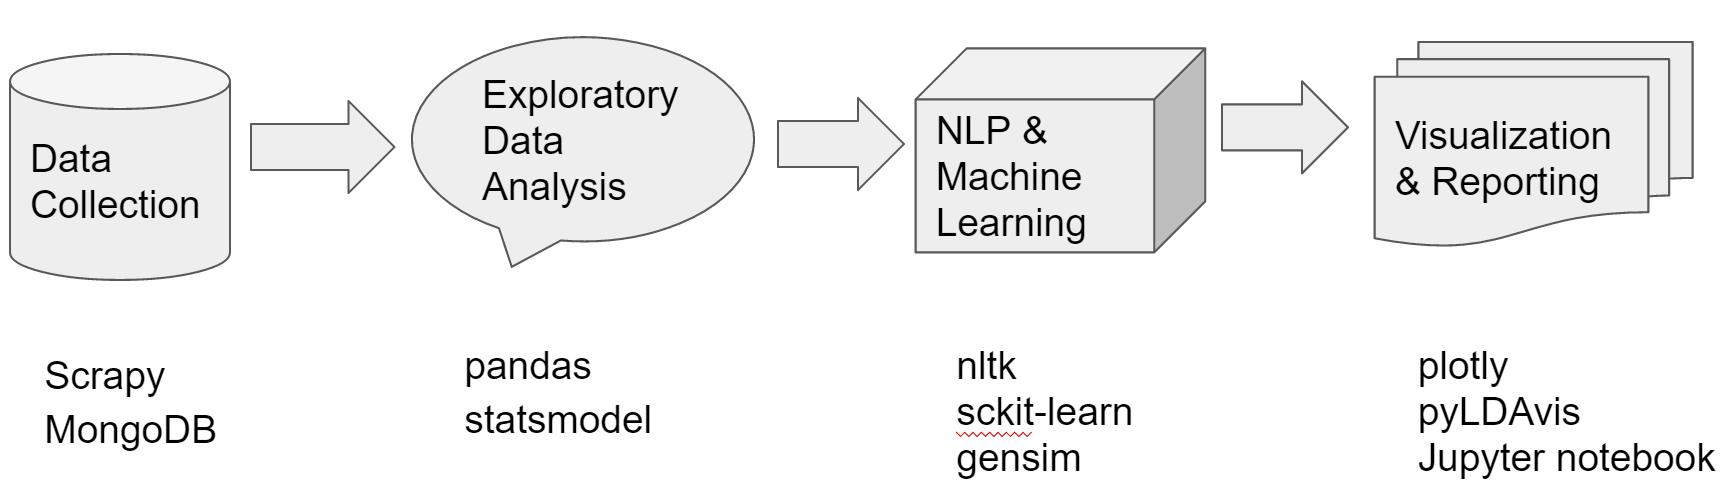

In [34]:
from IPython.display import Image
Image(filename='workflow.PNG',width=800, height=800)

## Data Collection

To collect our data, we found the Apple's app store websites provide a lot of useful information and they share a consistent web design pattern which makes web scraping easier. Note that we only collected the first indexing pages of different categories since they are shown as most popular apps. Then we scraped different links of apps. An example of [Spotify Music](https://itunes.apple.com/us/app/spotify-music/id324684580?mt=8) is showed below. Thus, our goal is to collect and store the various information on the web page for each app. We also identify some interesting characteristics, such as `Is_Multilingual`, `Is_Multiplatform` and `Has_InAppPurchased`. In the end, we collected about 5600 unique apps from ITune App Store and sotred into the Mongo Database.

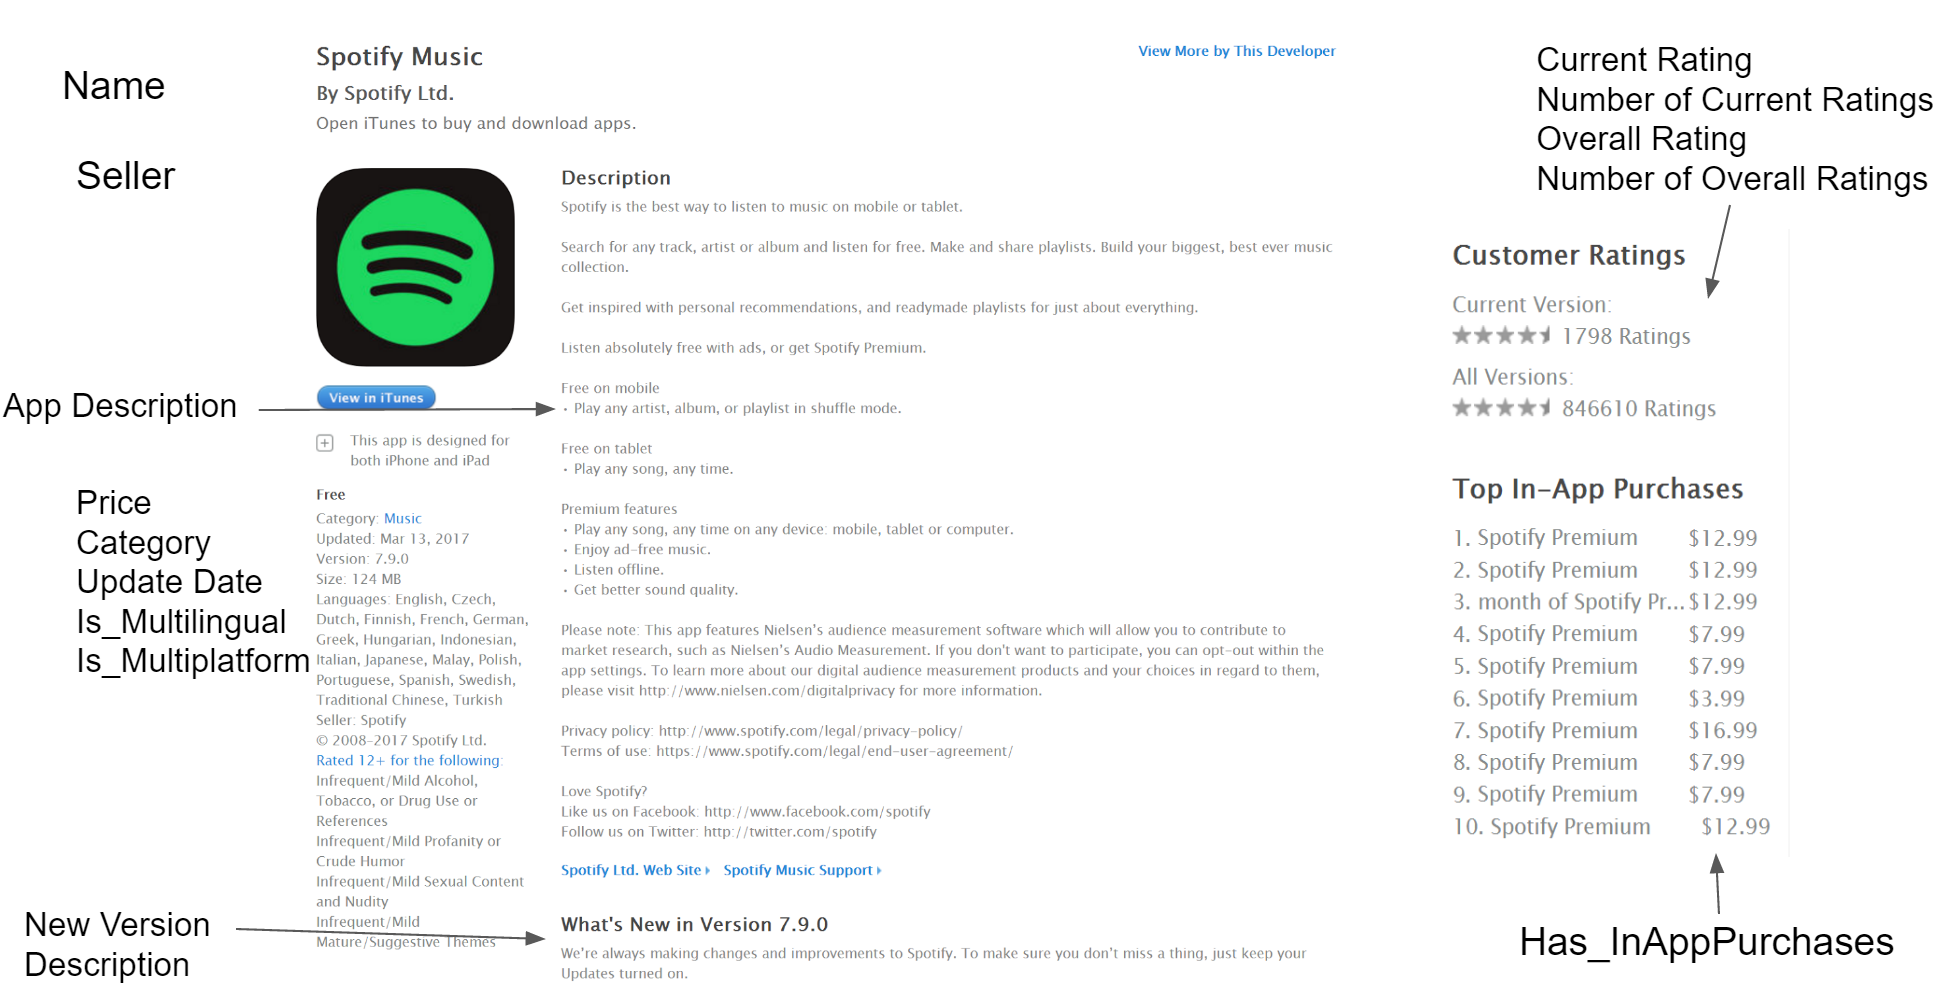

In [37]:
Image(filename='webscrape1.PNG',width=850, height=850)

In [36]:
Image(filename='webscrape2.PNG',width=850, height=850)

## Exploratory Data Analysis

### Distribution of most popular Apps in terms of category and overall rating
Let's check out the distribution of apps in terms of category and rating first. 

In [5]:
# for data manipulation
import numpy as np
import pandas as pd
# for MongoDB connection
import pymongo
import matplotlib as plt
# for statistical hypothesis testing
import scipy.stats
%matplotlib inline

In [6]:
# for interactive plotting
import plotly.plotly as py
import cufflinks as cf
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
cf.set_config_file(offline=True, theme='ggplot')
#print __version__ # requires version >= 1.9.0

In [7]:
def read_mongo(collection, query={}, host='localhost', port=27017, username=None, password=None, no_id=True):
    """ Read from Mongo and Store into DataFrame """
    # Connect to MongoDB and Make a query to the specific DB and Collection
    with pymongo.MongoClient(host, port) as client:
        table = client.appstore[collection]
        df = pd.DataFrame(list(table.find(query)))
        
    # Delete the _id
    if no_id:
        del df['_id']

    return df

In [9]:
apps_df = read_mongo('appitems')
rating_cleaned = {'1 star':1, "1 and a half stars": 1.5, '2 stars': 2, '2 and a half stars':2.5, "3 stars":3, "3 and a half stars":3.5, "4 stars": 4,
                 '4 and a half stars': 4.5, "5 stars": 5}
apps_df.overall_rating = apps_df.overall_rating.replace(rating_cleaned)
cate_cnt = apps_df.groupby(['category', 'overall_rating'])['id'].count().reset_index()
rate_cate_cnt = cate_cnt.pivot_table(index = 'category', columns = 'overall_rating', values = 'id', fill_value= 0)
rate_cate_cnt.iplot(kind = 'bar', barmode = 'stack', yTitle='Number of Apps', title='Distribution of Apps by Category and Rating', 
                    colorscale = 'Paired', theme='white', labels = 'Rating')

We can see that the Entertainment, Lifestyle and Photo types of apps are the most popular in terms of number of apps in our collection. Besides, the health&Fitness and Photo categories have the largest portions of high rated apps(Overall rating > 4).

### How to define the quality of apps?

We found that the dataset has current rating(numerical variable) and overall rating(categorical) and often times the overall rating won't be updated until the new version releases, which could be biased. We have to define a more balanced metric to evaluate the quality of an app to facilitate our further analysis. Although our metric is not perfect, it does help correct the bias for apps that didn't account for the new current ratings efficiently.

$$
\frac{number\;of\;current\;rating}{number\;of\;overall\;rating}* current\;rating + (1-\frac{number\;of\;current\;rating}{number\;of\;overall\;rating})* overall\;rating
$$

In [12]:
rating_df['weighted_rating'] = map(lambda a, b, c,d: np.divide(a,b)*c+(1-np.divide(a,b))*d, rating_df['num_current_rating'], 
                                   rating_df['num_overall_rating'], rating_df['current_rating'], rating_df['overall_rating'])
rating_df[['weighted_rating', 'current_rating','overall_rating']].iplot(kind='histogram', barmode='stack', theme='white', title = 'Distribution of Rating Metrics')

### Does in-app purchases significantly affect the user experiences of apps?

When looking at the reviews, there seem to be two kinds of thoughts about paid apps among users. The first is the common folk wisdom that "you get what you pay for", which is usually positive. The second kind of thought is that expensive apps are not worth buying, so those users would complain about the price tags. We want to run a statistical test to see whether in-app purchases significantly affect the user experiences of apps. Here, we would use the weighted rating we derived from the last step as the proxy of user experience for mobile apps.

We can answer this question by doing hypothesis testing. Since the distribution of ratings are not normal, obviously we can’t use t-test or one-way ANOVA test. Thus, we prefer to use Kruskal-Wallis H-test, a non-parametric test which only requires the independence assumption.

$H_0:$ The medians of two groups are the same. $H_1$: The medians of two groups are different.

In [13]:
free_df = apps_df[(apps_df['is_InAppPurcased'] == 0)&(pd.notnull(apps_df['overall_rating']))][["name","overall_rating", "current_rating", 'num_current_rating', "num_overall_rating"]]
paid_df = apps_df[(apps_df['is_InAppPurcased'] == 1)&(pd.notnull(apps_df['overall_rating']))][["name","overall_rating", "current_rating", 'num_current_rating', "num_overall_rating"]]
free_df['weighted_rating'] = map(lambda a, b, c,d: np.divide(a,b)*c+(1-np.divide(a,b))*d, free_df['num_current_rating'], 
                                   free_df['num_overall_rating'], free_df['current_rating'], free_df['overall_rating'])
paid_df['weighted_rating'] = map(lambda a, b, c,d: np.divide(a,b)*c+(1-np.divide(a,b))*d, paid_df['num_current_rating'], 
                                   paid_df['num_overall_rating'], paid_df['current_rating'], paid_df['overall_rating'])
free = list(free_df['weighted_rating'])
paid = list(paid_df['weighted_rating'])
scipy.stats.kruskal(free, paid)

KruskalResult(statistic=187.92790428584749, pvalue=9.0081895155668011e-43)

In [30]:
Image('ht1.PNG', width=500, height=500)

Thus, we can reject the null hypothesis. It's significant that providing in-app purchases does influent the user experiences of an app. The density plot seems to verify that the median weighted rating for paid apps should be higher than that of apps without in-app purchases.

### Do multiple languages influent the quality of apps?

Since apps with more than one languages can attract people with different native languages, so we get curious about the relationship between app quality(weighted rating) and whether the app has multiple languages. With the similar reasoning, we run a Kruskal-Wallis H-test. 

In [43]:
Image('ht2.PNG', width=500, height=500)

The null hypothesis is median quality for single-language apps and median quality for apps with multiple languages are the same. The alternative hypothesis is that the median quality for these two samples are not the same. For the result, we got p value significantly smaller than 0.05; so we should reject null hypothesis at significance level 0.05. Thus, we should conclude that the median of quality for these two samples are not the same and multiple languages do influent the quality of an app. The density plot seems to verify that the median weighted rating for apps with multiple languages is higher than that of apps with single language.

## NLP & Machine Learning

### Topic Modeling: How do people comment on their user experiences of apps? How do developers usually talk about their new version updates?

Discoverying the relevant and desired information from app reviews and new version description is useful for us to have a sense about the quality and problems of each app. For example, by analyzing the review comments, we can know what "topics" the users are most concerned about for an app; by analyzing the new version description and associating with the rating changes, we can investigate whether there are any different characteristics/topics in new version descriptions for apps with their ratings improved/lowered. One such technique in the field of text mining is Topic Modeling, which can be used to fetch the information that we are looking for. Topic Modeling is a process to automatically identify topics present in a text object and to derive hidden patterns exhibited by a text corpus. It's different from rule-based text mining approaches that use regular expressions or dictionary based keyword searching techniques. It is an unsupervised learning approach used for finding and observing the relavant key words in large clusters of texts. 

<b>Questions:</b>
* For app reviews analysis, here we define the good and bad quality apps based on the quality metric we created. Meanwhile, we choose the good reviews and bad reviews based on the review rating. If the review rating is no less than 4.0, it can be seen as a good review. If the review rating is no more than 2.5, it can be seen as a bad review. For details, please refer to this [notebook](https://github.com/jpzhangvincent/MobileAppMarketAnalysis/blob/master/notebooks/LDA%20for%20Topic%20Modeling%20(Q5).ipynb)

* For new version desctiption analysis, we used histogram to show the distribution of the ratio of number of current rating to overall rating as, which is used as a criterion to reduce the influences of lack of number of ratings for new version. We only used the app data whose ratio is over 10%. We diveded the rest data into two parts by using the difference between current rating and overall rating. we defined the improved apps as the differences are larger than 0.1, the worsen appes as the differences are smaller than -0.1. For details, please refer to this [notebook](https://github.com/jpzhangvincent/MobileAppMarketAnalysis/blob/master/notebooks/patterns%20for%20the%20apps%20improving%20higher%20current%20version%20ratings%20comparing%20to%20overall%20ratings.ipynb)
 
<b>Cleaning and Preprocessing:</b>

Data cleaning is essencial for generating a useful topic model. The steps below are common to most natural language processing methods:
   * Tokenizing: converting a document to its atomic elements.
   * Stopping: removing meaningless words.
   * Stemming: merging words that are equivalent in meaning.
   
<b>Latent Dirichlet Allocation</b>
* Latent Dirichlet Allocation is the most popular topic modeling technique. LDA assumes documents are produced from a mixture of topics. Those topics then generate words based on their probability distribution. Given a dataset of documents, LDA backtracks and tries to figure out what topics would create those documents in the first place. LDA is a matrix factorization technique. In vector space, any corpus (collection of documents) can be represented as a document-term matrix. The number of words we chose for every topic is 5. The potential topics are showed below.

In [18]:
from IPython.core.display import display, HTML
with open("good_rev.html",'r') as gr:
    good_rev = gr.read()
display(HTML(good_rev))

In [19]:
with open("bad_rev.html",'r') as br:
    bad_rev = br.read()
display(HTML(bad_rev))

Here we used `pyLDAvis` package to get the interactive topic modeling visualization. You can select specific topic using the selection bar on the left top. The right part shows the top 30 relevent terms for each topic. By comparing the comments for high-rated and low-rated apps, we found that
* For good apps, the comments have common features like: 
  1. It's free have some good features that satisfy customers'demand.
  2. It has good content and display, and customers are comfortable at vision, like screen.
  3. The speed is fast and low latency.
  4. It provids some help when customers using it.
  
* For the bad apps, from the result, we can see most topics include the word "time". We can infer that the speed and latency is the priority concern for users. Also, "money", "price" and "payment" occur, which shows price or in-app purchases can be disturbing. 

In [20]:
with open("improved_apps.html",'r') as ia:
    improved = ia.read()
display(HTML(improved))

In [21]:
with open("worsen_apps.html",'r') as wa:
    worse = wa.read()
display(HTML(worse))

We did similar topic modeling on the new version description with 3 topics since we have smaller corpus. Note that firstly we just filtered the common stop words then we found that main topics of the two parts apps are similar, they both contains 'fixed bugs', 'new features', 'upgrade', which means there is no different topics for the improved and worse apps' new version description. Then, we tried to add the same key topic words of two parts into the stop words. Interestingly, we got more different key topic words of improved apps and worsen apps. For the improved apps, the new version description usually refer to "some improvements on interface", "ask for feedbacks" and "ask for reviews on app store". And for the worsen apps, the common main topics reflects on  issues related to "ipad version", "music and video functions" and "account".

<b>Tips to improve results for LDA</b>
* Running LDA Model (Batch Wise LDA)
  * In order to retrieve most important topic terms, a corpus can be divided into batches of fixed sizes. Running LDA multiple times on these batches will provide different results, however, the best topic terms will be the intersection of all batches. 

* Part of Speech Tag Filter
  * POS tag filter is more about the context of the features than frequencies of features. Topic Modelling tries to map out the recurring patterns of terms into topics. However, every term might not be equally important contextually. For example, POS tag IN contain terms such as – “within”, “upon”, “except”. “CD” contains – “one”,”two”, “hundred” etc. “MD” contains “may”, “must” etc. These terms are the supporting words of a language and can be removed by studying their post tags.

### Supervised learning: Can you predict the rating of the new version for an app?

As we know, new versions & updates are very common and important for developers to improve their apps quality as well as collect feedback. We would like to build a model to predict the app rating when new version is released. This could be valuable for developer to have a better sense about their product. What's more, it could be useful for recommendation system for new apps when the ratings are not available yet. We extracted some useful features from the dataset. Note that our goal is to predict the new version rating, thus it doesn't make sense to use features that are relavent to the period after the new version release. We can't use the features like user reviews and number of current ratings. We will use the following features:

__App characteristics__
- overall rating(category)
- App category (category)
- Is_InAppPurcase(category)
- Is_multilingual(category)
- Is_multiplatform(category)
- Number of overall rating(log transform)
- AppFileSize(log transform)
- Time range between release date and extraction date(log transform)
	       
__Text Features from descriptions__:
- lengthOfText(character level)
- NumOfwords(word level)
- polarity 
- subjectivity

Aftet we clean the data and feature extraction, we are ready for building our machine learning model. Since the target variable current_rating is a continuous variable, it's obviously a regression problem. With the fantastic scikit-learn package, we used the ElasticNet and RandomForestRegressor models since they are good at controlling overfitting and have fast computation. For the time being, we have experimented and compared these two models based on the features extracted from the last step. With proper cross validation model evaluation and parameter tuning, the prediction results on the test set are  shown below. For more details, please check out the [notebook](https://github.com/jpzhangvincent/MobileAppMarketAnalysis/blob/master/notebooks/PredictNewAppVersionRating(Q7).ipynb)

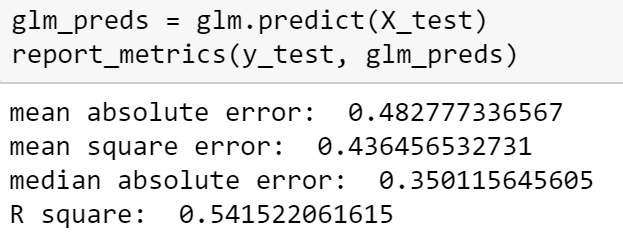

In [42]:
Image('glm_result.PNG',width=300, height=300)

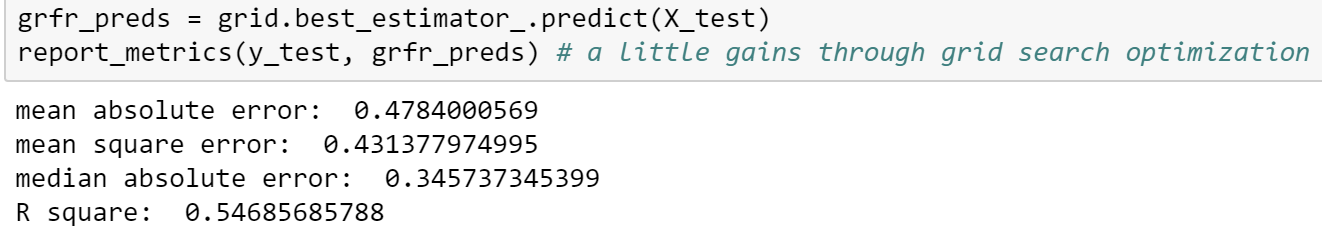

In [41]:
Image('rfr_result.PNG',width=600, height=600)

We can see that the optimized Random Forest Regressor performs a little better. However, there is room to improve the model performance considering the R square is just about 0.547. To improve the prediction, since the description usually reveals the features of the apps, we can try to incorporate the raw text data and see whether we can improve our model performance, which could indicate the desciption has some predictive power for user experiences and app quality. In future, we can combine the word representation features into the `pipeline` with `FeatureUnion` in `sckit-learn`.

## Conclusion

There have been surveys showing that people spend more and more time on mobile devices. It shows that mobile apps are becoming increasingly ubiquitous in our daily life. In this project, we analyze the mobile market from different angles. From the developer's perscpective, how to create a good app and what’s the users’ biggest concern are the most important questions. From the user and App Store administrator's perspective, how to measure and predict the app quality would be of greatest interest. We used statistical and machine learning methods to solve these questions. For data collecting, we established the infrastructure to smoothly collect data with the Scrapy framework, store and manage data in MongoDB. By creating customized metric to define the quality of apps, we conducted exploratory data analysis to answer questions like whether in-app purchases and multiple languages significantly affect the app’s ratings. Meanwhile, we applied Latent Dirichlet Allocation for topic modeling method to explore how people comment on user experiences of apps and what kind of characteristics for new version description of apps could have impact on improving or decreasing the app ratings. To predict the ratings of the new version for an app, we applied generalized linear model and random forest regression which achieve reasonable performance. In future, we plan to improve our ratings prediction model and build a Flask web Dashboard to better engage with possible stakeholders - app users, developers/marketers and App Store Adminstrators.